In [107]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso,Ridge,BayesianRidge,ElasticNet,HuberRegressor,LinearRegression,LogisticRegression,SGDRegressor

# Load and prepare data

In [2]:
df = pd.read_csv('/kaggle/input/fish-market/Fish.csv')

Information about dataset.

In [3]:
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [4]:
df.shape

(159, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [6]:
df.isna().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

In [95]:
TARGET = 'Weight'
X = df.drop([TARGET], axis=1)
y = df[TARGET]

Let's split the data into `test` and` train`.

In [70]:
RANDOM_STATE = 21
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [10]:
X_train.head()

,Species,Length1,Length2,Length3,Height,Width
45,Roach,20.5,22.5,25.3,7.0334,3.8203
111,Perch,32.5,35.0,37.3,11.4884,7.7957
146,Smelt,10.0,10.5,11.6,1.9720,1.1600
158,Smelt,13.8,15.0,16.2,2.9322,1.8792
54,Roach,29.5,31.7,35.0,9.4850,5.3550


In [11]:
y_train.head()

45     160.0
111    840.0
146      7.5
158     19.9
54     390.0
Name: Weight, dtype: float64

We will display the main information about the data for better understanding of the situation.

In [12]:
X_train.describe()

,Length1,Length2,Length3,Height,Width
count,111.000000,111.000000,111.000000,111.000000,111.000000
mean,26.188288,28.359459,31.092793,8.927363,4.459573
std,10.130626,10.866582,11.752707,4.335018,1.768310
min,7.500000,8.400000,8.800000,1.728400,1.148400
25%,19.000000,20.750000,22.500000,5.830250,3.316250
50%,25.000000,27.000000,29.300000,8.145400,4.234000
75%,33.600000,36.450000,40.150000,11.844900,6.098600
max,59.000000,63.400000,68.000000,18.957000,7.795700


# EDA

<AxesSubplot:>

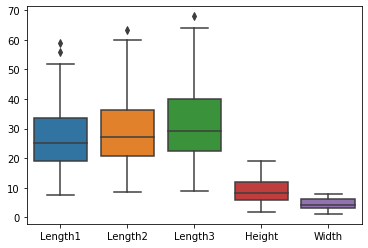

In [13]:
sns.boxplot(data = X_train)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Weight'>

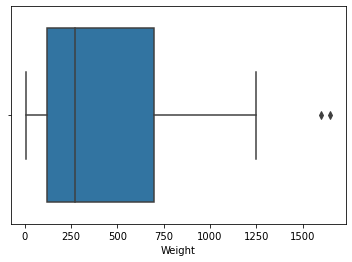

In [14]:
sns.boxplot(y_train)

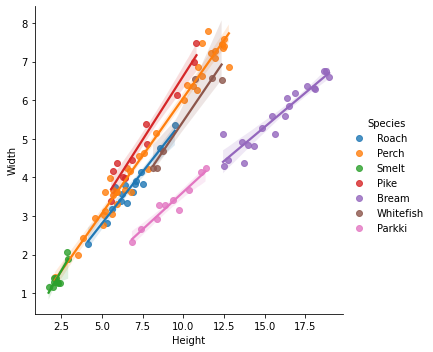

In [15]:
sns.lmplot(x='Height',y='Width', hue='Species', data=X_train)

<AxesSubplot:xlabel='Height', ylabel='Width'>

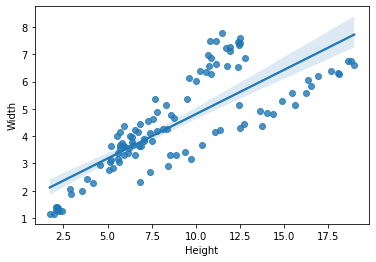

In [16]:
sns.regplot(x=X_train['Height'],y=X_train['Width'])

<AxesSubplot:xlabel='Height', ylabel='Width'>

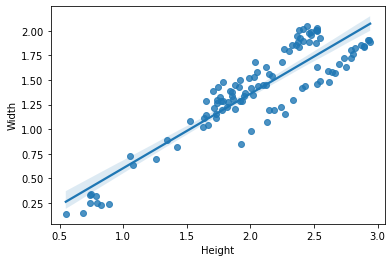

In [17]:
sns.regplot(x=np.log(X_train['Height']),y=np.log(X_train['Width']))

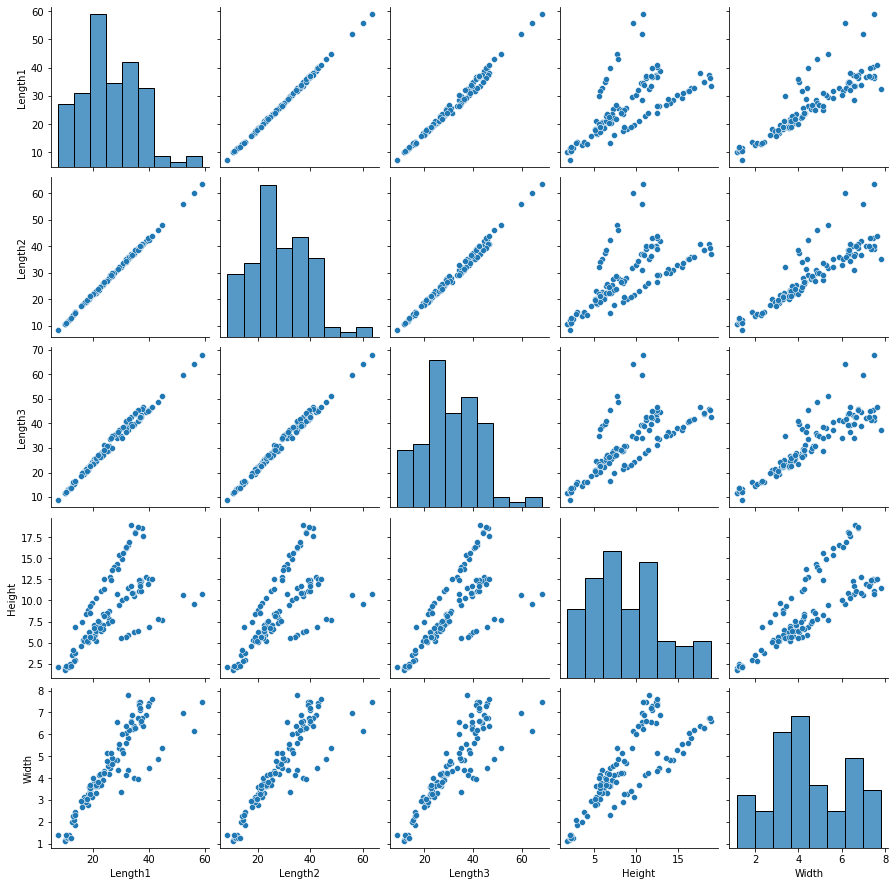

In [18]:
sns.pairplot(X_train)

In [18]:
train = X_train.join(y_train.to_frame())

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


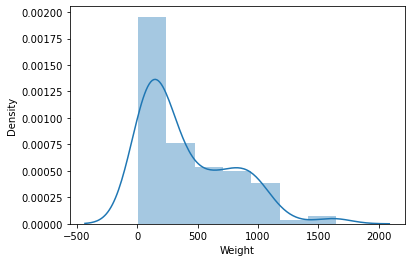

In [20]:
ax = sns.distplot(y_train, norm_hist=True)

Based on the graphs, the following preliminary estimates / conclusions can be made:

The features `Length1`, `Length2`, and `Length3` are strongly correlated as demonstrated by their proportional similarity when using the "describe()" method, visual inspection of the box plot, and intersections in the pairplot. This can be further confirmed by examining the heatmap. In linear models, we will perform regularization to counteract the effects of multicollinearity.

The MLplot graph indicates that each value of the "Species" feature is well-separated from the others, with "Parkki" and "Bream" being the best separated and "Perch" being the least separable. This suggests that the "Species" feature will be a useful predictor.

The `Height` and `Width` features are likely to have a poor correlation with each other and other features, and therefore are unlikely to be affected by the multicollinearity effect. This assumption is supported by the heatmap.

<AxesSubplot:>

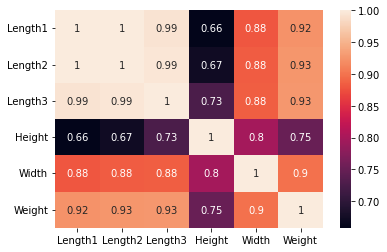

In [21]:
corr = train.corr()
condition = np.abs(corr[TARGET]) > 0.5
top_corr = corr.loc[condition,condition]
sns.heatmap(top_corr, annot=True)

As we can see, all the features are strongly correlated with the `TARGET`. Let's create another Dataframe in which we will normalize the features for potentially better compatibility with linear models.

In [84]:
def to_scaler_le(X_train):
    scaler = StandardScaler()
    le = LabelEncoder()
    X_train['Species'] = le.fit_transform(X_train['Species'])
    new_train = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(new_train, index=X_train.index, columns=X_train.columns)
    print(X_train_scaled)
    return X_train_scaled

      Species   Length1   Length2   Length3    Height     Width
45   0.926562 -0.564041 -0.541664 -0.495125 -0.438880 -0.363156
111 -0.235567  0.625858  0.613869  0.530547  0.593458  1.895175
146  1.507626 -1.605202 -1.650975 -1.666101 -1.611736 -1.874410
158  1.507626 -1.228401 -1.234983 -1.272927 -1.389233 -1.465849
54   0.926562  0.328384  0.308808  0.333959  0.129219  0.508671
..        ...       ...       ...       ...       ...       ...
120 -0.235567  1.072070  1.076082  0.975004  0.649443  1.570974
112 -0.235567  0.774596  0.752533  0.675850  0.452708  1.365898
48   0.926562 -0.415303 -0.403000 -0.332727 -0.322785 -0.354692
4   -1.397695  0.030909  0.059213  0.248487  0.814895  0.383126
56   2.088690 -0.207071 -0.171893 -0.153235 -0.181201 -0.119906

[111 rows x 6 columns]


<AxesSubplot:>

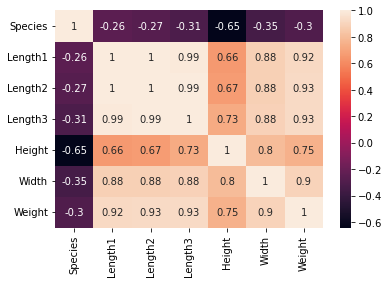

In [86]:
corr = (to_scaler_le(X_train).join(y_train.to_frame())).corr()
sns.heatmap(corr, annot=True)

In [92]:
X_scaled_le = to_scaler_le(X)

      Species   Length1   Length2   Length3    Height     Width
0   -1.332730 -0.305789 -0.282303 -0.106020  0.596579 -0.236529
1   -1.332730 -0.225507 -0.198054 -0.002337  0.821261 -0.066579
2   -1.332730 -0.235542 -0.179332 -0.010977  0.797341  0.165793
3   -1.332730  0.005302  0.054694  0.196390  0.879771  0.022621
4   -1.332730  0.025372  0.054694  0.239592  0.812835  0.426371
..        ...       ...       ...       ...       ...       ...
154  1.610382 -1.479903 -1.517960 -1.540309 -1.610359 -1.799403
155  1.610382 -1.459833 -1.499238 -1.531669 -1.530878 -1.873547
156  1.610382 -1.419692 -1.443072 -1.505748 -1.566687 -1.881402
157  1.610382 -1.309305 -1.321378 -1.384784 -1.427243 -1.398568
158  1.610382 -1.249094 -1.255851 -1.298381 -1.413341 -1.510440

[159 rows x 6 columns]


In [93]:
X_train_scaled_le, X_test_scaled_le, y_train_scaled_le, y_test_scaled_le = train_test_split(X_scaled_le, y, test_size=0.3, random_state=RANDOM_STATE)

In [102]:
scaler = StandardScaler()
X_onehot = pd.get_dummies(X)
X_scaled_onehot = pd.DataFrame(scaler.fit_transform(X_onehot), index = X_onehot.index, columns = X_onehot.columns)

In [103]:
X_train_scaled_onehot, X_test_scaled_onehot, y_train_scaled_onehot, y_test_scaled_onehot = train_test_split(X_scaled_onehot, y, test_size=0.3, random_state=RANDOM_STATE)

In [104]:
X_train_scaled_onehot.head()

,Length1,Length2,Length3,Height,Width,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
45,-0.576738,-0.553773,-0.512114,-0.453481,-0.355363,-0.53128,-0.272625,-0.737353,-0.346003,2.636285,-0.310728,-0.19803
111,0.627482,0.616357,0.524721,0.589183,2.010251,-0.53128,-0.272625,1.356203,-0.346003,-0.379322,-0.310728,-0.19803
146,-1.630431,-1.677098,-1.695835,-1.638070,-1.938409,-0.53128,-0.272625,-0.737353,-0.346003,-0.379322,3.218252,-0.19803
158,-1.249094,-1.255851,-1.298381,-1.413341,-1.510440,-0.53128,-0.272625,-0.737353,-0.346003,-0.379322,3.218252,-0.19803
54,0.326427,0.307442,0.325995,0.120300,0.557880,-0.53128,-0.272625,-0.737353,-0.346003,2.636285,-0.310728,-0.19803


Let's try different models to predict `Weight` values.

# Training

In [105]:
def evaluate_model(X_train, X_test, y_train, y_test, pipeline):
    pipeline.fit(X_train, y_train)
    pred_val = pipeline.predict(X_test)
    pred_train = pipeline.predict(X_train)

    print('Score for train:',pipeline.score(X_train, y_train))
    print('Score for test:',pipeline.score(X_test, y_test))
    
    return pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(y_train, pred_train))], 
        'train_R2': [r2_score(y_train, pred_train)],
        'val_RMSE': [np.sqrt(mean_squared_error(y_test, pred_val))],
        'val_R2': [r2_score(y_test, pred_val)]
    })

## One hot encodings

In [115]:
# Tune hyperparams, validation curves and feature engineering
models = [['DecisionTree :',DecisionTreeRegressor()],
           ['Linear Regression :', LinearRegression()],
           ['RandomForest :',RandomForestRegressor()],
           ['KNeighbours :', KNeighborsRegressor(n_neighbors = 2)],
           ['AdaBoostRegressor :', AdaBoostRegressor()],
           ['GradientBoostingRegressor: ', GradientBoostingRegressor()],
           ['Xgboost: ', XGBRegressor()],
           ['CatBoost: ', CatBoostRegressor(logging_level='Silent')],
           ['Lasso: ', Lasso()],
           ['Ridge: ', Ridge()],
           ['BayesianRidge: ', BayesianRidge()],
           ['ElasticNet: ', ElasticNet()],
           ['HuberRegressor: ', HuberRegressor()]]

for name, model in models:
    scores = evaluate_model(X_train_scaled_onehot, X_test_scaled_onehot, y_train_scaled_onehot, y_test_scaled_onehot, model)
    print(f'''Scores for {name} is 
{scores}
          
          ''')

Score for train: 1.0
Score for test: 0.9613919988144435
Scores for DecisionTree : is 
   train_RMSE  train_R2   val_RMSE    val_R2
0         0.0       1.0  61.387533  0.961392
          
          
Score for train: 0.9404586441231115
Score for test: 0.9142814015440214
Scores for Linear Regression : is 
   train_RMSE  train_R2   val_RMSE    val_R2
0   91.237883  0.940459  91.470078  0.914281
          
          
Score for train: 0.9943540834375176
Score for test: 0.9736146644048157
Scores for RandomForest : is 
   train_RMSE  train_R2   val_RMSE    val_R2
0   28.095261  0.994354  50.748456  0.973615
          
          
Score for train: 0.9877557148030474
Score for test: 0.9610832061579365
Scores for KNeighbours : is 
   train_RMSE  train_R2   val_RMSE    val_R2
0   41.374481  0.987756  61.632537  0.961083
          
          
Score for train: 0.990438318795466
Score for test: 0.9700212611819831
Scores for AdaBoostRegressor : is 
   train_RMSE  train_R2   val_RMSE    val_R2
0   36.56

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.835e+03, tolerance: 1.552e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


## LabelEncoder

In [116]:
for name, model in models:
    scores = evaluate_model(X_train_scaled_le, X_test_scaled_le, y_train_scaled_le, y_test_scaled_le, model)
    print(f'''Scores for {name} is 
{scores}
          
          ''')

Score for train: 1.0
Score for test: 0.9650002973298636
Scores for DecisionTree : is 
   train_RMSE  train_R2   val_RMSE  val_R2
0         0.0       1.0  58.448544   0.965
          
          
Score for train: 0.903732820284449
Score for test: 0.8577034279714169
Scores for Linear Regression : is 
   train_RMSE  train_R2    val_RMSE    val_R2
0  116.012548  0.903733  117.852483  0.857703
          
          
Score for train: 0.995459693475047
Score for test: 0.9744565177515779
Scores for RandomForest : is 
   train_RMSE  train_R2  val_RMSE    val_R2
0   25.194656   0.99546   49.9323  0.974457
          
          
Score for train: 0.9877626243809849
Score for test: 0.9620076679702464
Scores for KNeighbours : is 
   train_RMSE  train_R2   val_RMSE    val_R2
0   41.362805  0.987763  60.896102  0.962008
          
          
Score for train: 0.9888461507226899
Score for test: 0.9659484802744185
Scores for AdaBoostRegressor : is 
   train_RMSE  train_R2   val_RMSE    val_R2
0    39.48919 

### As observed, the use of one hot encoding has significantly improved the prediction capabilities of linear models, while the performance of tree models has remained relatively unchanged.

After making predictions, the following conclusions can be done:

1) `Linear regression` showed weaker performance compared to other methods, but normalizing the model using StandardScaler improved its performance slightly. Further efforts to address issues such as multicollinearity and non-ideal linearity in the model could result in even better predictions.

2) `KNN` outperformed linear regression due to the relatively small number of features compared to the number of rows in the dataframe.

3) `Random Forest` was the most effective method among those considered, as evidenced by its `RMSE` and `R2` scores, which indicate its high level of accuracy.

4) Among the boosting methods, `Gradient Boosting Regressor` and `CatBoost` showed the best results.